# Tally slurm total GPU hours for an account

This assumes that you have run

```bash
sacct -p pli-c --allusers --json > sacct_pli.json    
sacct -p pli --allusers --json > sacct_other.json    
```

on the server, printing out all jobs for the `pli` account.

Or for a larger time window, add `-S 2024-01-01 `

In [1]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
from slurm_analyzer import SLURMAnalyzer
import seaborn as sns
import pandas as pd
from datetime import datetime

In [2]:
json_data = Path("..", 'data',  'sacct_pli_all.json')

assert json_data.exists()

In [3]:
data = json.loads(json_data.read_text())

In [4]:
df = SLURMAnalyzer().parse(data)

In [5]:
del data

In [9]:
df.partition.value_counts()

partition
pli-c    65790
pli       7561
Name: count, dtype: int64

In [6]:
class Plot:
    def __init__(self, df: DF):
        self.df = df.copy()
        self._prepare_df()
    
    def _prepare_df(self):
        pass

In [33]:
class WaittimePlot(Plot):
    def _prepare_df(self):
        self.df = self.df.query("gpu_time >  600")
        self.suffix = "> 10min GPU time"
        

    def hist(self, bins="auto", hue="qos", **kwargs):
        # Create a figure and axis object
        _, ax = plt.subplots()

        df = self.df.query("age_days > -31").copy()
        clipval = 1.1*df["wait_time_h"].quantile(0.99)
        df["wait_time_h"] = df["wait_time_h"].clip(0, clipval)

        # Use Seaborn to create the histogram
        sns.histplot(data=df, x="wait_time_h", bins=bins, ax=ax, hue=hue, **kwargs)

        # Set the title and labels
        ax.set_title(f"Wait time by {hue} (last 31 days; {self.suffix})")
        ax.set_xlabel("Wait time [h]")
        ax.set_xlim(0., )
        ax.set_ylabel("Count")
    
    def boxplot_in_bins(self, var, bins):
        df = self.df.query("age_days > -31")

        col = f"{var}_custom_bins"
        df[col] = pd.cut(df[var], bins=bins, labels=False)
        fig, ax = plt.subplots()
        sns.boxplot(x=col, y='wait_time_h', data=df, ax=ax)
        ax.set_ylim(0, 24)

        # Set the title and labels
        ax.set_title(f"Wait Time vs {var} (last 31 days; {self.suffix})")
        ax.set_xlabel(f"{var}")
        ax.set_ylabel("Wait Time [h]")
        bin_labels = [ f"{a} - {b}" for a, b in zip(bins[:-1], bins[1:])]
        ax.set_xticklabels(bin_labels, rotation=45, ha='right')  # Rotate labels for better readability
    
    def plot_all(self):
        self.hist()
        self.hist(hue="partition",)
        self.boxplot_in_bins("gpu_time_h", [1, 10, 100, 500, 1000, 1e9])
        self.boxplot_in_bins("n_gpus", [0, 1, 2, 10, 16, 1e9])
        self.boxplot_in_bins("submission_hour", [0, 5, 8, 10, 12, 14, 16, 18, 24])
        self.boxplot_in_bins("age_days", [-1000, -100, -62, -31, -7, -6, -5,  -4, -3, -2, -1, 0])

/var/folders/g3/1y2_hl1j16scls01cxqm76s80000gn/T/ipykernel_36420/3890391625.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.cut(df[var], bins=bins, labels=False)
/var/folders/g3/1y2_hl1j16scls01cxqm76s80000gn/T/ipykernel_36420/3890391625.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels, rotation=45, ha='right')  # Rotate labels for better readability
/var/folders/g3/1y2_hl1j16scls01cxqm76s80000gn/T/ipykernel_36420/3890391625.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

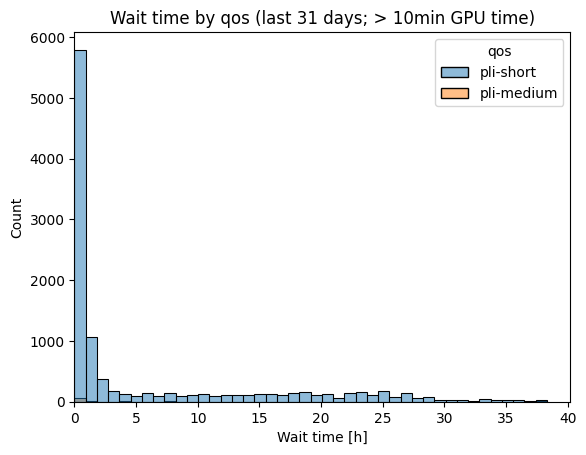

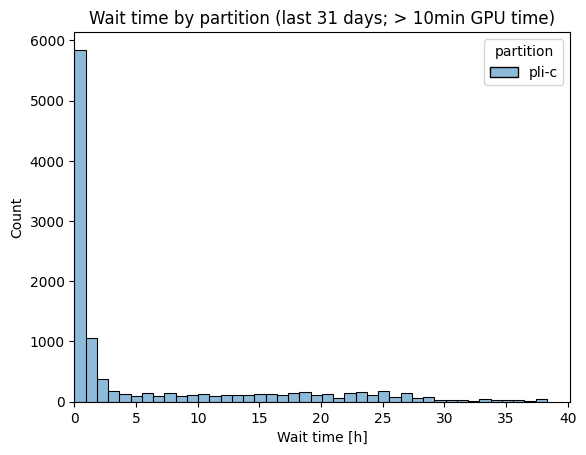

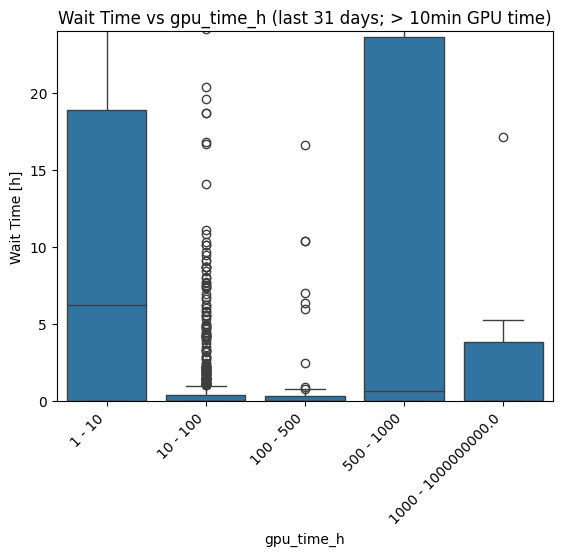

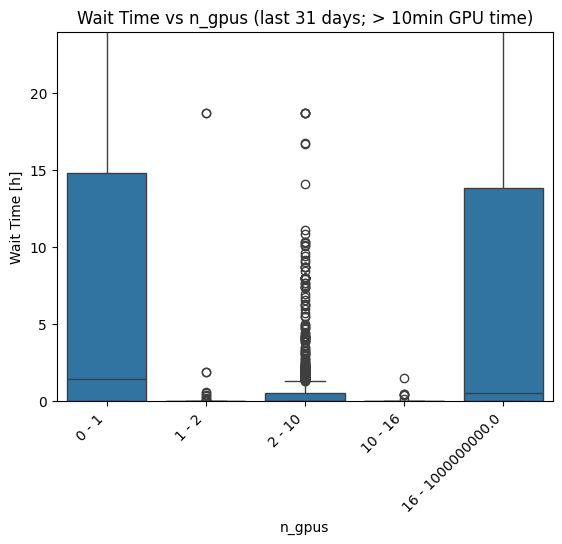

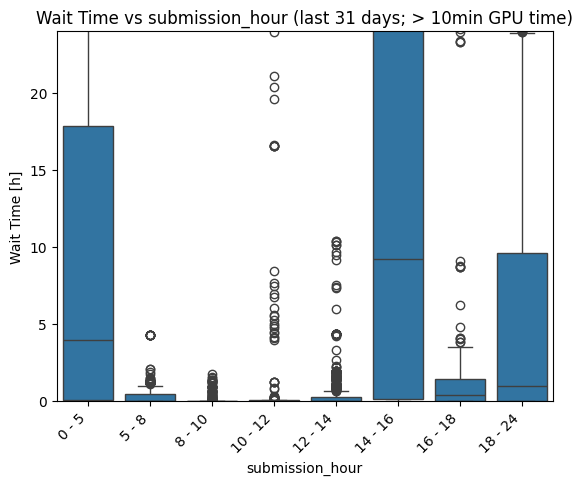

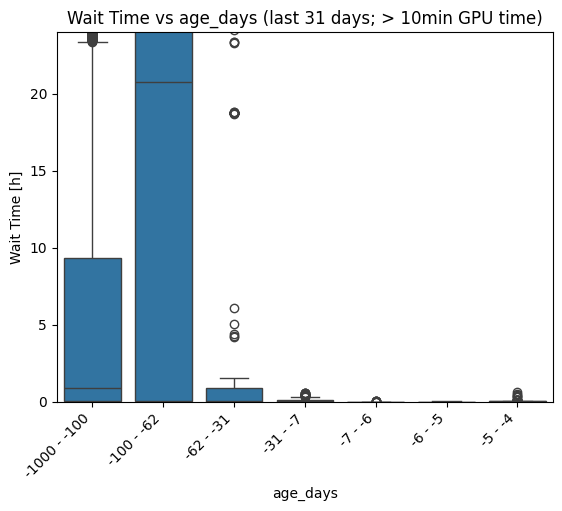

In [34]:
WaittimePlot(df).plot_all()